# Feature Selection

In [80]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
import time
from utils import *
import xgboost as xgb

In [23]:
def load_data(path):
    df = pd.read_csv(path, index_col='id')
    df.poor.fillna(False, inplace=True)
    return df

In [24]:
# load training data
a_train = load_data(DATA_PATHS['A']['train'])
b_train = load_data(DATA_PATHS['B']['train'])
c_train = load_data(DATA_PATHS['C']['train'])

In [31]:
def get_object_columns(df):
    obj = df.select_dtypes(include=['O'])
    del obj['country']
    return obj


def get_numeric_columns(df):
    obj = df.select_dtypes(include=['int64', 'float64'])
    return obj


def convert_objs_to_cat(df):
    """
    df must contain only Object columns
    """
    tmp = df.copy()
    for col in tmp.columns.tolist():
        tmp[col] = tmp[col].astype('category')
    tmp[tmp.columns.tolist()] = tmp[tmp.columns.tolist()].apply(lambda x: x.cat.codes)
    return tmp

In [32]:
ay_train = a_train.poor
a_train_objs = get_object_columns(a_train)
a_train_nums = get_numeric_columns(a_train)
a_train_cats = convert_objs_to_cat(a_train_objs)

In [6]:
a_train_objs.describe()

,wBXbHZmp,SlDKnCuu,KAJOWiiw,DsKacCdL,rtPrBBPl,tMJrvvut,jdetlNNF,maLAYXwi,vwpsXRGk,sArDRIyX,...,QZiSWCCB,sDGibZrP,CsGvKKBJ,OLpGAaEu,LrDrWRjC,JCDeZBXq,HGPWuGlV,GDUPaBQs,WuwrCsIY,AlDbXTlZ
count,8203,8203,8203,8203,8203,8203,8203,8203,8203,8203,...,8203,8203,8203,8203,8203,8203,8203,8203,8203,8203
unique,2,2,3,2,2,2,2,3,31,2,...,2,2,2,3,2,2,2,2,2,2
top,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,sehIp,sPNOc,MwLvg,...,wxJis,JqHnW,MaXfS,HxnJy,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq
freq,8095,6015,5252,7728,7560,7797,6928,6860,398,8139,...,5776,8196,7173,3640,7943,6199,8097,8141,7383,5433


In [7]:
a_train_nums.describe()

,nEsgxvAq,OMtioXZZ,YFMZwKrU,TiwRslOh
count,8203.000000,8203.000000,8203.000000,8203.000000
mean,-7.590638,17.464464,-2.985615,-4.191028
std,5.810942,10.853654,0.896245,4.472567
min,-70.000000,-127.000000,-4.000000,-31.000000
25%,-10.000000,12.000000,-4.000000,-7.000000
50%,-4.000000,12.000000,-3.000000,-3.000000
75%,-4.000000,21.000000,-2.000000,-1.000000
max,-4.000000,111.000000,1.000000,3.000000


In [1]:
def visualize_grassi(x, y):
    # Violin visualization
    data_n_2 = (x - x.mean()) / (x.std())
    data = pd.concat([y, data_n_2],axis=1)
    data = pd.melt(data,id_vars="poor",
                   var_name="features",
                   value_name='value')
    plt.figure(figsize=(10,10))
    sns.violinplot(x="features", y="value", hue="poor", data=data, split=True, inner="quart")
    plt.xticks(rotation=90)

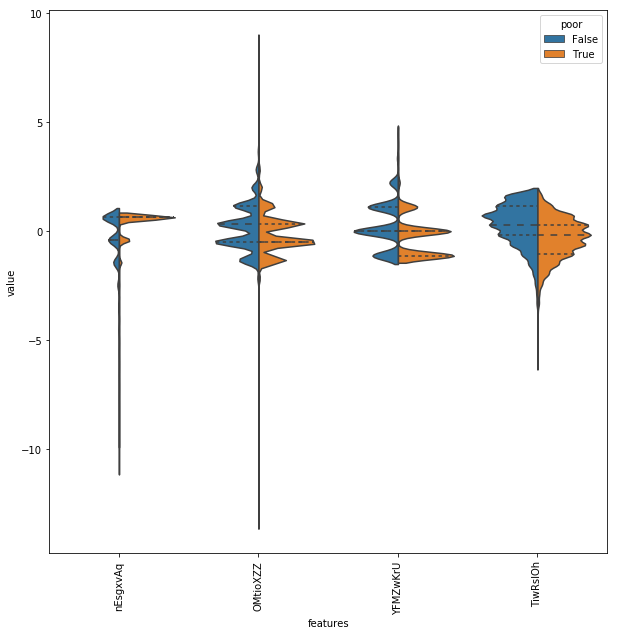

In [9]:
visualize_grassi(a_train_nums, ay_train)

Some of the numeric features seem to be correlated, like OMtioXZZ and YFMZwKrU. Lets see:

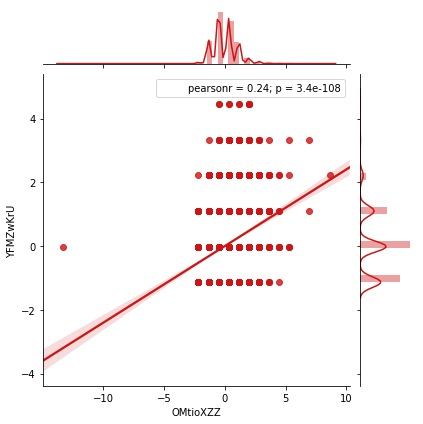

In [10]:
x = (a_train_nums - a_train_nums.mean()) / (a_train_nums.std())

sns.jointplot(x.loc[:,'OMtioXZZ'], x.loc[:,'YFMZwKrU'], kind="regg", color="#ce1414")

Nope. They dont seem highly correlated as the pearsonr score is 0.24

Lets check the categorical variables now. For that we can use a swarmplot:

In [62]:
def visualize_grassi_cate(x, y):
    data = pd.concat([y, x],axis=1)
    data = pd.melt(data, id_vars="poor",
                   var_name="features",
                   value_name='value')
    plt.figure(figsize=(10,10))
    sns.violinplot(x="features", y="value", hue="poor", data=data, split=True)
    plt.xticks(rotation=90)
#sns.swarmplot(x="day", y="total_bill", hue="sex", data=tips);

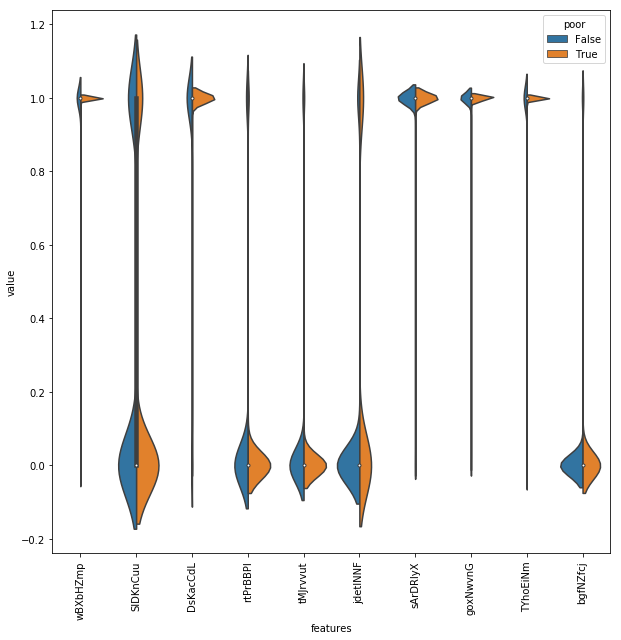

In [66]:
a_sub = a_train_cats[a_train_cats.columns[a_train_cats.max() == 1]]
a_big = a_train_cats.drop(a_sub.columns.tolist(), axis=1)
visualize_grassi_cate(a_sub.iloc[:, 0:10], ay_train)

Lets use a swarmplot instead:


In [69]:
def visualize_swarm(x, y):
    data = pd.concat([y, x],axis=1)
    data = pd.melt(data, id_vars="poor",
                   var_name="features",
                   value_name='value')
    plt.figure(figsize=(10,10))
    sns.swarmplot(x="features", y="value", hue="poor", data=data)
    plt.xticks(rotation=90)

In [71]:
visualize_swarm(a_sub.iloc[:, 0:10], ay_train)

Whatever, lets use a tool that comes with scikit learn:

In [76]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# find best scored 5 features
select_feature = SelectKBest(chi2, k=50).fit(a_sub, ay_train)

print('Score list:', select_feature.scores_)
print('Feature list:', a_sub.columns)

Score list: [  1.09040648e+00   7.28718956e+01   1.97521564e+01   1.32519387e+02
   7.57615521e+01   3.17138998e+02   3.92192218e-02   4.08305909e-02
   2.01788481e+00   1.02020332e+01   1.05920650e-02   2.79782222e+01
   2.52273957e+00   3.92915104e+00   5.99673100e+01   3.89841609e+01
   2.19908873e+02   3.88625075e-01   8.41637143e+01   4.39366272e+00
   2.44477889e+01   2.93394257e-04   4.84241558e-04   9.66978918e+00
   3.92192218e-02   1.40420472e+02   8.83200283e+02   3.47693302e-04
   3.85268960e+02   4.40359263e+00   2.22180000e+01   5.81676733e-01
   1.13006635e-03   1.68274471e-01   2.05014476e-01   2.22724737e+01
   2.51002118e+01   9.25124173e+01   8.14377766e+01   3.80134856e+01
   4.76263753e+02   1.33679826e+00   6.41341622e-01   1.38271803e+01
   4.24108468e-03   5.06062652e-01   6.05978359e+02   1.15204444e+01
   4.23161344e-02   4.93550776e-02   1.42063589e+02   5.43106667e+01
   3.02490550e+01   1.00278488e+01   6.19077117e+01   1.56437070e+01
   1.03151105e+01   5.

In [95]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
a_train = pd.read_csv(DATA_PATHS['A']['train'], index_col='id')
a_train.poor.fillna(False, inplace=True)
ay_train = np.ravel(a_train.poor.astype(int))
data = pre_process_data(a_train.drop('poor', axis=1))

clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5, scoring='neg_log_loss')
rfecv = rfecv.fit(data, ay_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', data.columns[rfecv.support_])

Input shape:	(8203, 344)
After standardization (8203, 344)
After converting categoricals:	(8203, 859)
Optimal number of features : 565
Best features : Index(['nEsgxvAq', 'OMtioXZZ', 'YFMZwKrU', 'TiwRslOh', 'SlDKnCuu_GUusz',
       'SlDKnCuu_alLXR', 'KAJOWiiw_BIZns', 'KAJOWiiw_TuovO', 'DsKacCdL_QGgpH',
       'rtPrBBPl_feupP',
       ...
       'OLpGAaEu_USRak', 'OLpGAaEu_etZsD', 'JCDeZBXq_LPtkN', 'JCDeZBXq_UyAms',
       'HGPWuGlV_WKNwg', 'HGPWuGlV_vkbkA', 'WuwrCsIY_AITFl', 'WuwrCsIY_GAZGl',
       'AlDbXTlZ_aQeIm', 'AlDbXTlZ_cecIq'],
      dtype='object', length=565)


Lets train a xgboost and check the results:

In [96]:
# Prepare data to train
test_size = 0.2
train = data[data.columns[rfecv.support_]]

xgb_ax_train, xgb_ax_test, xgb_ay_train, xgb_ay_test = prepare_data(train, ay_train, test_size=test_size, xgb_format=True)

In [97]:
num_round = 3000
#params = {'max_depth': 15, 'eta': 0.01, 'silent': 0, 'lambda': 0.5, 'alpha': 0.5, 'lambda_bias': 0.5, 'min_child_weight': 1, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'seed': 42}
params = {'max_depth': 15, 'eta': 0.01, 'silent': 0, 'lambda': 0.5, 'alpha': 0.5, 'lambda_bias': 0.5, 'min_child_weight': 1, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'seed': 42}

xgb_a = train_xgb_model(xgb_ax_train, params=params, num_round=num_round)

In [98]:
a_loss_train, a_loss_test = cross_validate(xgb_ax_train, xgb_ax_test, xgb_ay_train, xgb_ay_test, xgb_a)

print("A Loss. Train: {} - Test: {}".format(a_loss_train, a_loss_test))

A Loss. Train: 0.3931912914721542 - Test: 5.223861152460701
